63f78014766fd30436c18a79_Hyperspace - navbar logo.png

# Hybrid Search with Hyperspace - Academic Papers Dataset
This notebook demonstrates the use of Hyperspace for a hybrid search over a dataset of academic papers. The search combines vector search and keyword matching to find relevant papers. We will create a straightforward filtering function that focuses on papers within the same category, gives preference to papers by the same submitter with negative bias to papers without a license.

# Hybrid search with Hyperspace
This notebook combines Approximate KNN (HNSW) with metadata filtering. In this scheme, Hyperspace uses the post-filtering approach, by which the KNN score is first calculated, and filtering is applied in following step.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hyper-space-io/QuickStart/blob/master/DataSets/arXiv/arXiv_semantic_search.ipynb)


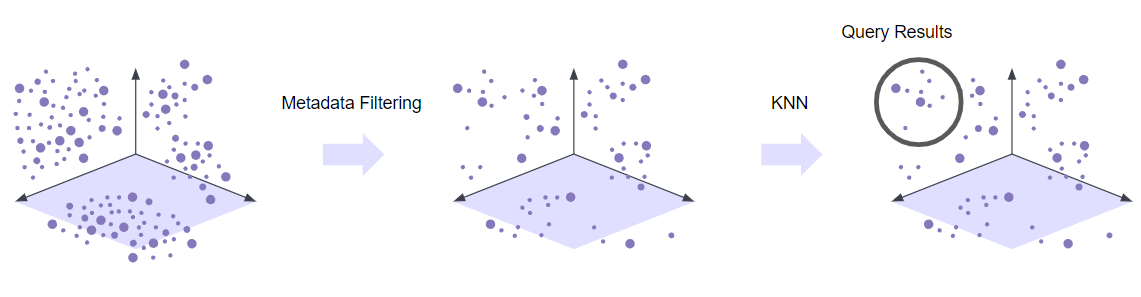


## Pre Filtering and ANN Recall Reduction
An inherent consequence of the pre-filtering approach is the dilution of the vector space prior to the KNN. While this effect does not alter the results of brute-force KNN, ANN approaches like IVF and HNSW may experience a reduction in recall. To better understand this result, consider scenarios in which nearby neighbors are irrelevant to the search, but their neighbors are. In such cases, the ANN method may fail to identify these relevant neighbors, as illustrated below.

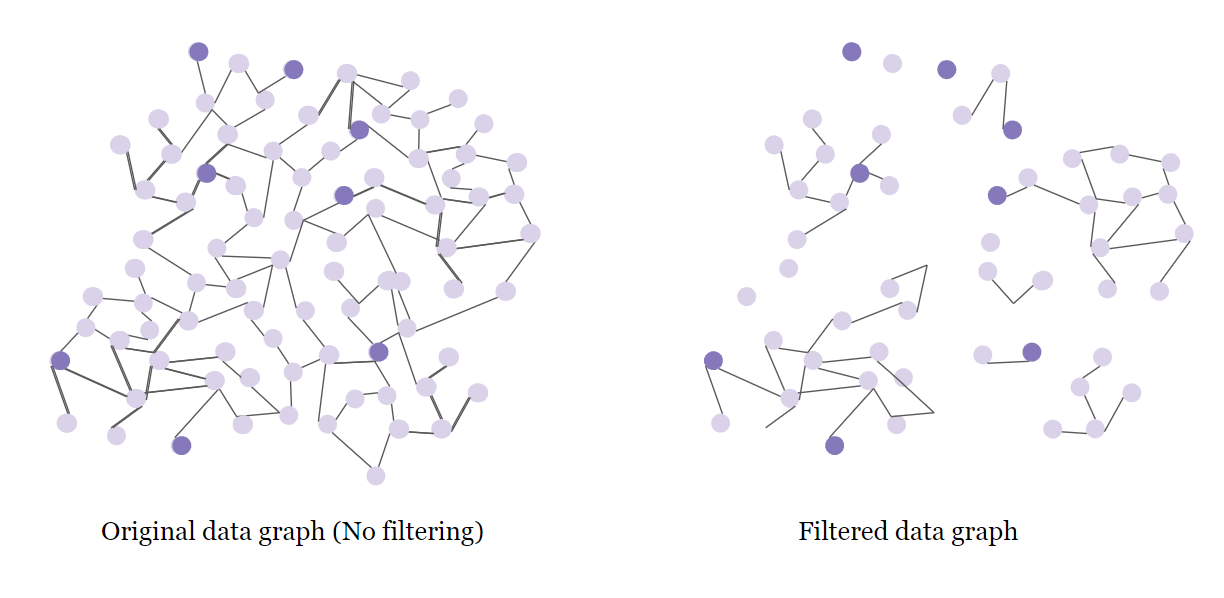


# The Datset
The dataset includes a list of academic papers from arXiv, vector embedding of their description and their metadata. The dataset can be downloaded from [here](http://hyperspace-datasets.s3.amazonaws.com/arXiv_data.zip).


## The Metadata Fields
The metadata includes the following fields:
1. **id** [float] - paper unique id
2. **title** [string] - paper title
3. **submitter** [string] - name of person who submitted the paper
4. **categories** [list[string]] - list of categories which include the paper
5. **label** [list[string]] - labels aplied to paper
6. **license** [string] - license type
7. **update_date_ts** [integer] - update time in unix format

We will use the combination of an embedded vector data and metadata, to create a hybrid search.

# Setting up the Hyperspace environment
Working with Hyperspace requires the followin steps

1. Install the client API
2. Create data config file
3. Connect to a server
4. Create collection
5. Ingest data
6. Run query

## 1. Install the client API
You can install the Hyperspace API directly from Git by executing the following command:

In [ ]:
pip install git+https://github.com/hyper-space-io/hyperspace-py

### Download dataset

In [ ]:
from urllib.request import urlretrieve
import os

def download_data(url, file_name):
    """
    url (str): URL of the file to download.
    file_name (str): Local path where the file will be saved.
    """
    # Check if the file already exists and is not empty
    if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
        print(f"The file {file_name} already exists and is not empty.")
    else:
        try:
            # Attempt to download the file from `url` and save it locally under `file_name`
            urlretrieve(url, file_name)
            # Check if the file was downloaded and is not empty
            if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
                print(f"Successfully downloaded {file_name}")
            else:
                print("Download failed or file is empty.")
                
        except Exception as e:
            print(f"An error occurred: {e}")

import zipfile
def unzip_file(path_to_zip_file):
    directory_to_extract_to = './'
    try:
        with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
            zip_ref.extractall(directory_to_extract_to)
        print(f'Success! Files have been extracted to {directory_to_extract_to}')

    except zipfile.BadZipFile:  # Handle a bad zip file
        print("Error: The file is a bad zip file. Unable to unzip.")
    except FileNotFoundError:  # Handle the file not being found
        print("Error: The file was not found. Please check the path.")
    except Exception as e:  # Handle other exceptions
        print(f"An error occurred: {e}")


In [ ]:
data_url = "http://hyperspace-datasets.s3.amazonaws.com/arXiv_data.zip"
download_data(data_url, "./arXiv_data.zip")
unzip_file("./arXiv_data.zip")

#2. Connect to a server

Once the Hyperspace API is installed, you can access database by creating a local instance of the Hyperspace client. This step requires host address, username and password, provided by Hyperspace

In [ ]:
import hyperspace
from getpass import getpass

username = "USERNAME"
host = "HOST_URL"

hyperspace_client = hyperspace.HyperspaceClientApi(host=host, username=username, password=getpass())


It is recommended to check the status before proceeding, using the command:

In [ ]:
collections_info = hyperspace_client.collections_info()
display(collections_info)

#3.   Create a Data Schema File

As other search databases, Hyper-Space database requires a configuration file that outlines the data schema. Attached below is a config file that corresponds to the fields of the given dataset.

For vector fields, we also provide the index type to be used, and the metric. . Current options for index include "**brute_force**", "**hnsw**", "**ivf**", and "**bin_ivf**" for binary vectors, and "**IP**" ([inner product](https://en.wikipedia.org/wiki/Inner_product_space)) as a metric for floating point vectors and "**Hamming**" ([hamming distance](https://en.wikipedia.org/wiki/Hamming_distance)) for binary vectors.
Here, we use "brute_force" (exact KNN) with inner product.

In [ ]:
import json

config = {
    "configuration": {
        "doc_id": {
            "type": "keyword",
            "id": True
        },
        "id": {
            "type":"float"
        },
        "title": {
            "type":"keyword"
        },
        "submitter": {
            "type":"keyword"
        },
        "categories": {
            "type":"keyword",
            "struct_type":"list"
        },
        "labels": {
            "type":"keyword",
            "struct_type":"list"
        },
        "license": {
            "type":"keyword"
        },
        "update_date": {
            "type":"keyword"
        },
        "update_date_ts": {
            "type":"integer"
        },
        "embedded_abstract": {
            "type": "dense_vector",
            "dim": 384,
            "index_type" : "brute_force",
            "metric": "IP"
        }
    }
}
config_file_path = 'arXiv_config.json'
with open(config_file_path, 'w') as f:
    f.write(json.dumps(config, indent=2))


## 4. Create Collection
The Hyperspace database stores data within Collections, which are distinct segments within the database.
Each search is then perfomed within a collection. We create a collection using the command "**create_collection**(schema_filename, collection_name)".

In [ ]:
collections_info["collections"]

In [ ]:
list(collections_info["collections"].keys())

In [ ]:
collection_name = 'all-MiniLM-L6-v2_arXiv'
if collection_name not in hyperspace_client.collections_info()["collections"]:
    hyperspace_client.create_collection('arXiv_config.json', collection_name)

hyperspace_client.collections_info()

# 5. Ingest data

In the next step, we ingest the dataset in batches. The number documents in each batch can be controlled by the user, and specifically, it can be increased to reduce ingestion time.
Batches of data are added using the add_batch(batch, collection_name) command
Ingestion of 1m documents may take several minutes.

In [ ]:
import numpy as np
vectors_path = "1m-vectors.npy"
metadata_path = "1m-payloads.jsonl"

BATCH_SIZE = 1000
vecs = np.load(vectors_path)

batch = []
with open(metadata_path) as data:
    for i, (metadata_row, vec) in enumerate(zip(data, vecs)):
        row = {key: value for key, value in json.loads(metadata_row).items() if key in config["configuration"].keys()}
        row['categories'] = row['categories'].split()
        row['embedded_abstract'] = np.ndarray.tolist(vec)
        row['doc_id'] = str(i)
    
        batch.append(row)
    
        if i % BATCH_SIZE == 0:
            response = hyperspace_client.add_batch(batch, collection_name)
            batch.clear()
            print(i, response)
# Vector search requires a commit
hyperspace_client.commit(collection_name)

# 6. Define Logic and Run a Query
Let us construct a Hyperspace hybrid search query.  We will randomly select a paper from the database and search for similar ones. The 'boost'  fields in the query object enable us to control the relative weights of classic search and vector search scores.

In [ ]:
import inspect

def set_score_function(func, collection_name, score_function_name='func'):
    source = inspect.getsource(func)
    with open('sf.py', 'w') as f:
        f.write(source)
    hyperspace_client.set_function('sf.py', collection_name, score_function_name)
    


def arXiv_score_func(params, doc):
    score = 0.0

    if match('categories'):

        if match('submitter'):
            score += 1

        if params['license'] is None:
            score *= 0.2

    if match('title'):
        score = 0

    return score

set_score_function(arXiv_score_func, collection_name=collection_name, score_function_name='similarity_sf')


In [ ]:
input_document = hyperspace_client.get_document(collection_name, '2000')
print(input_document['title'], "\n======================================\n", input_document['submitter'], "\n", input_document['categories'])

Let us begin with classic search

In [ ]:
results = hyperspace_client.search({'params': input_document},
                                        size=10,
                                        function_name='similarity_sf',
                                        collection_name=collection_name)

for i, result in enumerate(results['similarity']):
  vector_api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
  print(i + 1, "id", result['document_id'],  ":", vector_api_response['title'], ",", vector_api_response['submitter'], ",", vector_api_response['categories'])


In the next step, we use hybrid search

In [ ]:
query_with_knn = {
    'params': input_document,
    'knn' : [{'field': 'query',"boost":  0.001},
             {'field': 'embedded_abstract',"boost": 100}]
}

results = hyperspace_client.search(query_with_knn,
                                        size=10,
                                        function_name='similarity_sf',
                                        collection_name=collection_name)

for i, result in enumerate(results['similarity']):
  vector_api_response = hyperspace_client.get_document(document_id=result['document_id'], collection_name=collection_name)
  print(i + 1, "id", result['document_id'],  ":", vector_api_response['title'], ",", vector_api_response['submitter'], ",", vector_api_response['categories'])


The returned documents have similar submitter name, as expected from the metadata filtering.

This notebook gave a simple example of the use of the Hyperspace engine for hybrid search. Hyperspace can support complicated use cases with large databases, in extremley low latency.